## Part C: Compute evaluation performances 

This notebook contains all the code used to compute the evaluation performances (space and space-time validation) of the models calibrated using the three geology maps to infer their respective HRUs. 


Alongside the other notebooks, it covers all the analysis performed in: "How landscape data quality affects our perception of dominant processes in large-sample hydrology studies?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

# Import the modules

In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
import geopandas as gpd
import re

#warnings.filterwarnings("ignore")

## Set the path to the data

In [2]:
# Path to where the EStreams dataset is stored
# Eawag
path_estreams = r'/Users/nascimth/Documents/data/EStreams'

## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

path_data = r"/Users/nascimth/Documents/data"

## Read the files

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [4]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [5]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [6]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


#estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
#estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<00:00, 1071.89it/s]


In [7]:
# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'../data/network_estreams_moselle_108_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)
estreams_attributes_clipped_filters

,Unnamed: 0,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,group
basin_id,,,,,,,,,,,,,,,,,,,,,
LU000018,0,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,...,0.015,0.015,17.0,39.0,61.0,0.0,0.0,100.0,0.0,Group_1
LU000010,1,6,Hunnebuer,LU,LU_CONTACTFORM,Eisch,6.079524,49.729184,6.079524,49.729184,...,0.026,0.026,16.0,42.0,58.0,0.0,1.0,99.0,0.0,Group_1
LU000001,2,17,Bigonville,LU,LU_CONTACTFORM,Sure,5.801399,49.869821,5.801399,49.869821,...,0.000,0.000,9.0,1.0,0.0,99.0,100.0,0.0,0.0,Group_1
DERP2028,3,2674030900,Eisenschmitt,DE,DE_RP,Salm,6.718000,50.048000,6.718000,50.048000,...,0.000,0.000,10.0,80.0,7.0,13.0,79.0,20.0,1.0,Group_1
FR000183,4,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,...,0.000,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0,Group_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR003271,107,A782101001,La Seille Ã Nomeny,FR,FR_EAUFRANCE,La Seille à Nomeny,6.227788,48.888271,6.227788,48.888271,...,0.429,0.436,5.0,8.0,92.0,0.0,0.0,100.0,0.0,Group_7
FR003301,108,A930108040,La Sarre Ã Wittring,FR,FR_EAUFRANCE,La Sarre à Wittring,7.150066,49.053225,7.150066,49.053225,...,0.436,2.205,16.0,17.0,83.0,0.0,15.0,85.0,0.0,Group_7
DERP2003,109,2620050500,Bollendorf,DE,DE_RP,Sauer,6.359000,49.851000,6.359000,49.851000,...,1.627,4.160,65.0,17.0,30.0,53.0,50.0,50.0,0.0,Group_7


In [10]:
# Python implementation
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [46]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [16]:
fast

Module: superflexPy
Element: fast
Parameters:
	fast_k : 0.01
	fast_alpha : 2.0
States:
	fast_S0 : k

In [12]:
import os
import glob

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*moselle*comp*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


In [14]:
all_param_dicts.keys()

dict_keys(['moselle_best_params_globcomp_Group_7_2', 'moselle_best_params_globcomp_Group_5_2', 'moselle_best_params_contcomp_Group_2_2', 'moselle_best_params_globcomp_Group_1_2', 'moselle_best_params_contcomp_Group_6_2', 'moselle_best_params_contcomp_Group_4_2', 'moselle_best_params_globcomp_Group_3_2', 'moselle_best_params_globcomp_Group_4_2', 'moselle_best_params_contcomp_Group_3_2', 'moselle_best_params_contcomp_Group_1_2', 'moselle_best_params_globcomp_Group_6_2', 'moselle_best_params_contcomp_Group_5_2', 'moselle_best_params_globcomp_Group_2_2', 'moselle_best_params_contcomp_Group_7_2', 'moselle_best_params_contcomp_Group_3', 'moselle_best_params_globcomp_Group_4', 'moselle_best_params_regicomp_Group_6_2', 'moselle_best_params_globcomp_Group_5', 'moselle_best_params_contcomp_Group_2', 'moselle_best_params_regicomp_Group_4_2', 'moselle_best_params_globcomp_Group_7', 'moselle_best_params_globcomp_Group_6', 'moselle_best_params_contcomp_Group_1', 'moselle_best_params_contcomp_Group_5

In [48]:
class PowerReservoirWithKBasedS0(PowerReservoir):
    def __init__(self, parameters, states, approximation, id):
        # Dynamically find key corresponding to 'k'
        k_keys = [key for key in parameters if key.endswith('k')]
        if not k_keys:
            raise ValueError(f"Cannot find any parameter ending with 'k'. Keys received: {list(parameters.keys())}")

        # Ensure k_value is numeric
        k_value = float(parameters[k_keys[0]])

        # Compute S0 proportional to k and ensure it's a float
        factor = 0.3 * 3.432  # Example factor
        adjusted_states = dict(states)
        adjusted_states['S0'] = float(factor / k_value)

        # Initialize base class
        super().__init__(parameters, adjusted_states, approximation, id)


In [ ]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    slow = PowerReservoirWithKBasedS0(
        parameters={'k': 1e-4, 'alpha': 1.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='slow'
    )

    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
        id='low')

    high = Unit(
        layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output

def is_valid_key(k):
    # Exclude keys that end in Group_X_2
    return not re.search(r'Group_\d+_2$', k)

def is_valid_key_2(k):
    # Include only keys that end in Group_X_2
    return re.search(r'Group_\d+_2$', k)

In [30]:
catchments_ids = "FR003250"

## Model all time-series using all possible combinations of params

In [50]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_dict = {}
output_continental_dict = {}
output_global_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict[key] = output

100%|██████████| 7/7 [01:04<00:00,  9.19s/it]


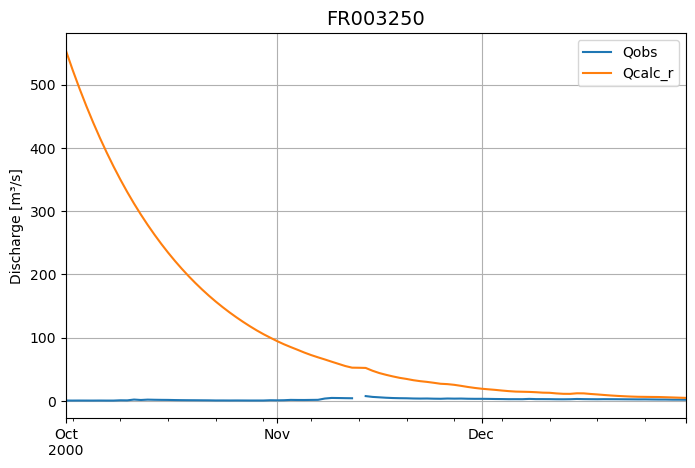

In [58]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-2000','09-30-2015', freq='D'))

gauge_id="FR003250"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_dict["moselle_best_params_regicomp_Group_3"][gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2000"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

In [61]:
500*0.3

150.0

In [51]:
output_regional_dict[gauge_id]

NameError: name 'gauge_id' is not defined

In [55]:
output_regional_dict["moselle_best_params_regicomp_Group_3"]["FR003250"]


[array([5.53699745e+02, 5.22791911e+02, 4.93612000e+02, ...,
        2.00490732e-01, 1.88787465e-01, 1.78133669e-01])]

In [16]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_8801 = {}
output_continental_dict_8801 = {}
output_global_dict_8801 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_8801[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_8801[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_8801[key] = output

100%|██████████| 7/7 [00:59<00:00,  8.55s/it]


In [ ]:
# Create the concatenated data for the complete series analysis
path_inputs = '../data/models/input/subset_1988_2001'
observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'
observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    #observations_cal[key] = np.concatenate([arr1, arr2])
    # Remove the first 365 days from the second dataset
    arr2_trimmed = arr2[365:] if arr2.size > 365 else np.array([])

    observations_cal[key] = np.concatenate([arr1, arr2_trimmed])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    #quality_masks_cal[key] = np.concatenate([arr1, arr2])
    # Remove the first 365 days from the second dataset
    arr2_trimmed = arr2[365:] if arr2.size > 365 else np.array([])

    quality_masks_cal[key] = np.concatenate([arr1, arr2_trimmed])

In [18]:
import numpy as np

# Load both input files
path_inputs_1 = '../data/models/input/subset_1988_2001/inputs.npy'
path_inputs_2 = '../data/models/input/subset_2001_2015/inputs.npy'

inputs1 = np.load(path_inputs_1, allow_pickle=True).item()
inputs2 = np.load(path_inputs_2, allow_pickle=True).item()

# Initialize new dictionaries
precipitation_cal = {}
temperature_cal = {}
evaporation_cal = {}

for key in inputs1.keys():
    # Get (P, T, PET) tuples from each period
    p1, t1, pet1 = map(np.atleast_1d, inputs1[key])
    p2, t2, pet2 = map(np.atleast_1d, inputs2.get(key, ([], [], [])))


    p2 = p2[365:] if p2.size > 365 else np.array([])
    t2 = t2[365:] if t2.size > 365 else np.array([])
    pet2 = pet2[365:] if pet2.size > 365 else np.array([])


    # Concatenate and assign
    precipitation_cal[key] = np.concatenate([p1, p2])
    temperature_cal[key] = np.concatenate([t1, t2])
    evaporation_cal[key] = np.concatenate([pet1, pet2])


In [19]:
output_global_dict_cal = {}

for param_key in output_global_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_8801:
        merged_outputs = {}

        for gauge_id in output_global_dict[param_key]:
            if gauge_id in output_global_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_8801, series_recent])
                # Remove first 365 days from recent series
                series_recent_trimmed = series_recent[365:] if series_recent.size > 365 else np.array([])
                concatenated = np.concatenate([series_8801, series_recent_trimmed])
                
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_cal[param_key] = merged_outputs

In [20]:
output_continental_dict_cal = {}

for param_key in output_continental_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_8801:
        merged_outputs = {}

        for gauge_id in output_continental_dict[param_key]:
            if gauge_id in output_continental_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_8801, series_recent])
                
                # Remove first 365 days from recent series
                series_recent_trimmed = series_recent[365:] if series_recent.size > 365 else np.array([])
                concatenated = np.concatenate([series_8801, series_recent_trimmed])

                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_cal[param_key] = merged_outputs

In [21]:
output_regional_dict_cal = {}

for param_key in output_regional_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_8801:
        merged_outputs = {}

        for gauge_id in output_regional_dict[param_key]:
            if gauge_id in output_regional_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_8801, series_recent])
                
                # Remove first 365 days from recent series
                series_recent_trimmed = series_recent[365:] if series_recent.size > 365 else np.array([])
                concatenated = np.concatenate([series_8801, series_recent_trimmed])

                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_cal[param_key] = merged_outputs

## Space-time validation

In [26]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_val_dict = {}
output_continental_val_dict = {}
output_global_val_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_val_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_val_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_val_dict[key] = output

100%|██████████| 7/7 [00:59<00:00,  8.51s/it]


In [27]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_0115 = {}
output_continental_dict_0115 = {}
output_global_dict_0115 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_0115[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_0115[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_0115[key] = output

100%|██████████| 7/7 [01:04<00:00,  9.27s/it]


In [28]:
output_global_dict_val = {}

for param_key in output_global_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_0115:
        merged_outputs = {}

        for gauge_id in output_global_val_dict[param_key]:
            if gauge_id in output_global_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_val_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_recent, series_8801])
                
                # Remove first 365 days from recent series
                series_8801_trimmed = series_8801[365:] if series_8801.size > 365 else np.array([])
                concatenated = np.concatenate([series_recent, series_8801_trimmed])

                
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_val[param_key] = merged_outputs

In [29]:
output_continental_dict_val = {}

for param_key in output_continental_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_0115:
        merged_outputs = {}

        for gauge_id in output_continental_val_dict[param_key]:
            if gauge_id in output_continental_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_val_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_recent, series_8801])
                
                # Remove first 365 days from recent series
                series_8801_trimmed = series_8801[365:] if series_8801.size > 365 else np.array([])
                concatenated = np.concatenate([series_recent, series_8801_trimmed])

                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_val[param_key] = merged_outputs

In [30]:
output_regional_dict_val = {}

for param_key in output_regional_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_0115:
        merged_outputs = {}

        for gauge_id in output_regional_val_dict[param_key]:
            if gauge_id in output_regional_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_val_dict[param_key][gauge_id])
                #concatenated = np.concatenate([series_recent, series_8801])
                
                # Remove first 365 days from recent series
                series_8801_trimmed = series_8801[365:] if series_8801.size > 365 else np.array([])
                concatenated = np.concatenate([series_recent, series_8801_trimmed])

                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_val[param_key] = merged_outputs

## Save the time-series in netcdfs

In [34]:
import xarray as xr
import numpy as np

# Adjust these according to your data
group_suffixes = ["Group_1", "Group_2", "Group_3", "Group_4", "Group_5", "Group_6", "Group_7"]

gauge_ids = list(observations_cal.keys())  # Your observations dict should be preloaded
time_index = pd.date_range(start="1988-10-01", end="2015-09-30", freq='D')

In [35]:
ds_inputs = xr.Dataset(
    data_vars={
        "observation": (["gauge_id", "date"], [observations_cal[g] for g in gauge_ids]),
        "precipitation": (["gauge_id", "date"], [precipitation_cal[g] for g in gauge_ids]),
        "temperature": (["gauge_id", "date"], [temperature_cal[g] for g in gauge_ids]),
        "evaporation": (["gauge_id", "date"], [evaporation_cal[g] for g in gauge_ids]),
    },
    coords={
        "gauge_id": gauge_ids,
        "date": time_index
    }
)

ds_inputs.to_netcdf(rf"../results/sim/space-time/inputs.nc", engine="scipy")

In [ ]:
ds_inputs = xr.Dataset(
    data_vars={
        "observation": (["gauge_id", "date"], [observations_cal[g] for g in gauge_ids]),
        "precipitation": (["gauge_id", "date"], [precipitation_cal[g] for g in gauge_ids]),
        "temperature": (["gauge_id", "date"], [temperature_cal[g] for g in gauge_ids]),
        "evaporation": (["gauge_id", "date"], [evaporation_cal[g] for g in gauge_ids]),
    },
    coords={
        "gauge_id": gauge_ids,
        "date": time_index
    }
)

ds_inputs.to_netcdf(rf"../results/sim/space/notconcatenated/inputs.nc", engine="scipy")

In [ ]:
# Build datasets
datasets = {}

for suffix in group_suffixes:
    reg_key = f"moselle_best_params_regicomp_{suffix}"
    cont_key = f"moselle_best_params_contcomp_{suffix}"
    glob_key = f"moselle_best_params_globcomp_{suffix}"

    reg_data = []
    cont_data = []
    glob_data = []
    group_gauge_ids = []

    for gauge in gauge_ids:
        if gauge in output_regional_dict_val[reg_key] and \
           gauge in output_continental_dict_val[cont_key] and \
           gauge in output_global_dict_val[glob_key]:

            reg_data.append(output_regional_dict_val[reg_key][gauge][0])
            cont_data.append(output_continental_dict_val[cont_key][gauge][0])
            glob_data.append(output_global_dict_val[glob_key][gauge][0])
            group_gauge_ids.append(gauge)

    if group_gauge_ids:
        ds = xr.Dataset(
            data_vars={
                "regional": (["gauge_id", "date"], reg_data),
                "continental": (["gauge_id", "date"], cont_data),
                "global": (["gauge_id", "date"], glob_data)
            },
            coords={
                "gauge_id": group_gauge_ids,
                "date": time_index
            }
        )
        datasets[suffix] = ds

# Save each group to a separate NetCDF file using scipy (no need for netCDF4)
for suffix, ds in datasets.items():
    ds.to_netcdf(rf"../results/sim/space-time/notconcatenated/simu_compl_{suffix}.nc", engine="scipy")


In [ ]:
# Build datasets
datasets = {}

for suffix in group_suffixes:
    reg_key = f"moselle_best_params_regicomp_{suffix}"
    cont_key = f"moselle_best_params_contcomp_{suffix}"
    glob_key = f"moselle_best_params_globcomp_{suffix}"

    reg_data = []
    cont_data = []
    glob_data = []
    group_gauge_ids = []

    for gauge in gauge_ids:
        if gauge in output_regional_dict_cal[reg_key] and \
           gauge in output_continental_dict_cal[cont_key] and \
           gauge in output_global_dict_cal[glob_key]:

            reg_data.append(output_regional_dict_cal[reg_key][gauge][0])
            cont_data.append(output_continental_dict_cal[cont_key][gauge][0])
            glob_data.append(output_global_dict_cal[glob_key][gauge][0])
            group_gauge_ids.append(gauge)

    if group_gauge_ids:
        ds = xr.Dataset(
            data_vars={
                "regional": (["gauge_id", "date"], reg_data),
                "continental": (["gauge_id", "date"], cont_data),
                "global": (["gauge_id", "date"], glob_data)
            },
            coords={
                "gauge_id": group_gauge_ids,
                "date": time_index
            }
        )
        datasets[suffix] = ds

# Save each group to a separate NetCDF file using scipy (no need for netCDF4)
for suffix, ds in datasets.items():
    ds.to_netcdf(rf"../results/sim/space/notconcatenated/simu_compl_{suffix}.nc", engine="scipy")


# End